In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
!pip install datasets
from datasets import load_dataset

You should consider upgrading via the 'C:\Users\tamer\OneDrive - Høgskulen på Vestlandet\Dokumenter\3 År\DAT255 Deep learning\toxicity2\toxicityPython39\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
dataset = load_dataset("google/civil_comments")
print(dataset['train'][0])

{'text': "This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!", 'toxicity': 0.0, 'severe_toxicity': 0.0, 'obscene': 0.0, 'threat': 0.0, 'insult': 0.0, 'identity_attack': 0.0, 'sexual_explicit': 0.0}


In [3]:
print(type(dataset))

<class 'datasets.dataset_dict.DatasetDict'>


In [4]:
# load dataset
train_dataset = load_dataset("google/civil_comments", split="train")
print(len(train_dataset['text']))

1804874


In [5]:
label_cols = [
    'toxicity', 'severe_toxicity', 'obscene', 'threat', 
    'insult', 'identity_attack', 'sexual_explicit'
]

# filter data
def keep_example(example):
    text = example["text"]
    if text.strip() == "":
        return False  # Exclude empty text
    labels = [example[col] for col in label_cols]
    if any(label >= 0.5 for label in labels):
        return True  # Keep if any label >= 0.5
    if all(label == 0.0 for label in labels):
        return True  # Or if they are all zero
    return False  # Exclude the rest

# Applay filter
filtered_dataset = train_dataset.filter(keep_example)

# Check results
print(f"Total after filtering: {len(filtered_dataset)}")
print(filtered_dataset[0])

Filter:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Total after filtering: 1391091
{'text': "This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!", 'toxicity': 0.0, 'severe_toxicity': 0.0, 'obscene': 0.0, 'threat': 0.0, 'insult': 0.0, 'identity_attack': 0.0, 'sexual_explicit': 0.0}


In [6]:
# Count the number of rows containing each label > 0.5
for label in label_cols:
    count = sum(example[label] >= 0.5 for example in filtered_dataset)
    print(f"{label}: {count}")

toxicity: 144334
severe_toxicity: 13
obscene: 9603
threat: 4280
insult: 106534
identity_attack: 13410
sexual_explicit: 4686


In [7]:
multi_label_count = sum(
    sum(example[label] >= 0.5 for label in label_cols) > 1
    for example in filtered_dataset
)
print(f"Rows with more than one label >= 0.5: {multi_label_count}")


Rows with more than one label >= 0.5: 122070


In [8]:
only_zero_labels = sum(
    all(example[label] == 0.0 for label in label_cols)
    for example in filtered_dataset
)

print(f"Rows with all labels == 0.0: {only_zero_labels}")

Rows with all labels == 0.0: 1242544


In [9]:
exactly_one_label = sum(
    sum(example[label] >= 0.5 for label in label_cols) == 1
    for example in filtered_dataset
)

print(f"Rows with exactly one label >= 0.5: {exactly_one_label}")

Rows with exactly one label >= 0.5: 26477


Rows with label >= 0.5 (and their number is the sum):

Rows with more than one label >= 0.5: 122,070

Rows with exactly one label >= 0.5: 26,477
Total = approximately 148,547 rows

This is the unhealthy portion of the data.

We take the same number of "clean" texts (with all labels = 0.0), and their number is:

Rows with all labels == 0.0: 1,242,544

So we take a random sample of 148,547 of them.

In [10]:
from datasets import Dataset
from datasets import concatenate_datasets
import random

# Number of rows containing labels >= 0.5
positive_dataset = filtered_dataset.filter(
    lambda example: any(example[label] >= 0.5 for label in label_cols)
)
print(f"positive_dataset: {len(positive_dataset)}")

# Number of rows containing all labels = 0.0
neutral_dataset = filtered_dataset.filter(
    lambda example: all(example[label] == 0.0 for label in label_cols)
)
print(f"neutral_dataset: {len(neutral_dataset)}")

# Randomly sample clean texts with the same number of toxic ones.
balanced_neutral = neutral_dataset.shuffle(seed=42).select(range(len(positive_dataset)))
print(f"balanced_neutral: {len(balanced_neutral)}")

# Merge the two samples
balanced_dataset = concatenate_datasets([positive_dataset, balanced_neutral])

print(f"Balanced dataset size: {len(balanced_dataset)}")


Filter:   0%|          | 0/1391091 [00:00<?, ? examples/s]

positive_dataset: 148547


Filter:   0%|          | 0/1391091 [00:00<?, ? examples/s]

neutral_dataset: 1242544
balanced_neutral: 148547
Balanced dataset size: 297094


In [11]:
print(balanced_dataset)

Dataset({
    features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit'],
    num_rows: 297094
})


In [12]:
# Clean the texts :
import re

def clean_text(example):
    text = example["text"].lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return {"text": text}

# Apply cleaning using .map() on the full dataset
balanced_dataset = balanced_dataset.map(clean_text)

Map:   0%|          | 0/297094 [00:00<?, ? examples/s]

In [19]:
# Remove empty and null text
cleaned_dataset = balanced_dataset.filter(lambda x: x["text"] not in ["", None])

# Check data size after cleaning
print(f"Number of rows after cleaning: {len(cleaned_dataset)}")

Number of rows after cleaning: 297057


In [20]:
cleaned_dataset.save_to_disk("cleaned_balanced_civil_comments")

Saving the dataset (0/1 shards):   0%|          | 0/297057 [00:00<?, ? examples/s]

In [122]:
positive_dataset = cleaned_dataset.filter(
    lambda example: any(example[label] >= 0.5 for label in label_cols)
)
print(f"positive_dataset: {len(positive_dataset)}")

positive_dataset: 148547


In [126]:
print(positive_dataset[200])

{'text': 'more than  lanes of new traffic does not fix congestion  you can not build your way out of conjection  findings suggest that both road capacity expansions and extensions to public transit are not appropriate policies with which to combat traffic congestion this leaves congestion pricing as the main candidate tool to curb traffic congestion tolls reduce congestion  the crc would have reduced congestion  if for no other reason people dont like to pay tolls stupid logic but that what studies suggest  more bridges the more congestion portland just say no', 'toxicity': 0.699999988079071, 'severe_toxicity': 0.0, 'obscene': 0.0, 'threat': 0.0, 'insult': 0.6000000238418579, 'identity_attack': 0.0, 'sexual_explicit': 0.0}


In [58]:
df = pd.DataFrame(cleaned_dataset)
df.head()

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit
0,haha you guys are a bunch of losers,0.893617,0.021277,0.000000,0.0,0.872340,0.021277,0.000000
1,ur a shtty comment,0.666667,0.047619,0.638095,0.0,0.333333,0.000000,0.009524
2,its ridiculous that these guys are being calle...,0.600000,0.000000,0.100000,0.1,0.600000,0.000000,0.000000
3,this story gets more ridiculous by the hour an...,0.500000,0.000000,0.000000,0.0,0.300000,0.000000,0.000000
4,angry trolls misogynists and racists oh my it ...,0.500000,0.000000,0.000000,0.0,0.500000,0.100000,0.000000


In [59]:
# Check null or None
print("Null or None values:")
print(df.isnull().sum())

# Check only empty text in the text column
print("\nEmpty string values in 'text':")
print((df["text"] == "").sum())

Null or None values:
text               0
toxicity           0
severe_toxicity    0
obscene            0
threat             0
insult             0
identity_attack    0
sexual_explicit    0
dtype: int64

Empty string values in 'text':
0


In [91]:
# lables
labels = df[df.columns[1:]].values

# texts
texts = df['text'].astype(str).values

In [95]:
print(type(texts))
print(texts.shape)

<class 'numpy.ndarray'>
(297057,)


In [96]:
print(type(labels))
print(labels.shape)

<class 'numpy.ndarray'>
(297057, 7)


In [97]:
is_empty_string = df['text'] == ''
count_empty_string = is_empty_string.sum()
print("Number of values ​​that equal an empty string:", count_empty_string)

Number of values ​​that equal an empty string: 0


In [98]:
df['text'].isnull().sum()

np.int64(0)

In [99]:
filtered_texts = []
filtered_labels = []

for text, label in zip(texts, labels):
    if text.strip(): 
        filtered_texts.append(text)
        filtered_labels.append(label)

texts = filtered_texts
labels = filtered_labels

In [100]:
MAX_WORDS=20000

In [101]:
vectorizer = TextVectorization(
    max_tokens=MAX_WORDS,
    output_sequence_length=300,  
    output_mode='int'
)

vectorizer.adapt(texts)

In [ ]:
# Convert data to Dataset
dataset = tf.data.Dataset.from_tensor_slices((texts, labels))

dataset = dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Data organization
dataset = dataset.cache()
dataset = dataset.shuffle(10000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [103]:
len(dataset)

9283

In [104]:
# Split into train / val / test
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Bidirectional, Dense, Embedding

In [106]:
model = Sequential()
model.add(Input(shape=(300,)))
# Create the embedding layer
model.add(Embedding(MAX_WORDS+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(7, activation='sigmoid'))

In [107]:
from tensorflow.keras.metrics import Precision, Recall, AUC
import tensorflow as tf

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
)



In [108]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 300, 32)             │         640,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 731,815 (2.79 MB)

 Trainable params: 731,815 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

In [109]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [110]:
history = model.fit(train, 
                    epochs=6, 
                    validation_data=val,
                    batch_size=32,
                    callbacks=[early_stop]       
                   )

Epoch 1/6
6498/6498 ━━━━━━━━━━━━━━━━━━━━ 857s 131ms/step - auc: 0.8489 - loss: 0.3258 - precision: 0.9953 - recall: 0.4386 - val_auc: 0.7258 - val_loss: 2.9470e-04 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/6
6498/6498 ━━━━━━━━━━━━━━━━━━━━ 794s 122ms/step - auc: 0.8875 - loss: 0.3038 - precision: 0.9985 - recall: 0.4503 - val_auc: 0.7402 - val_loss: 5.4729e-04 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/6
6498/6498 ━━━━━━━━━━━━━━━━━━━━ 790s 122ms/step - auc: 0.9010 - loss: 0.2972 - precision: 0.9992 - recall: 0.4531 - val_auc: 0.7371 - val_loss: 3.4080e-04 - val_precision: 1.0000 - val_recall: 0.0435


In [111]:
model.save('Blanced_model.keras')
print("model saved successfully!")

model saved successfully!


In [112]:
import numpy as np

# Extract properties and classes from val
X_val = []
y_val = []

for batch in val:
    features, labels = batch
    X_val.append(features)
    y_val.append(labels)

# Convert labels to Numpy array
y_val = np.concatenate([y.numpy() for y in y_val], axis=0)


Confusion Matrix for 'toxicity':
[[59384     2]
 [    6     0]]


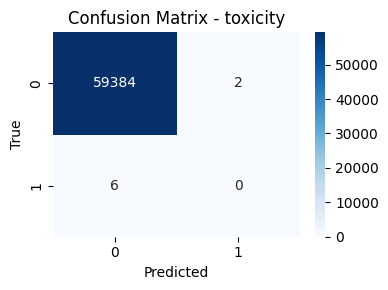


Confusion Matrix for 'severe_toxicity':
[[59392]]


C:\Users\tamer\OneDrive - Høgskulen på Vestlandet\Dokumenter\3 År\DAT255 Deep learning\toxicity2\toxicityPython39\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


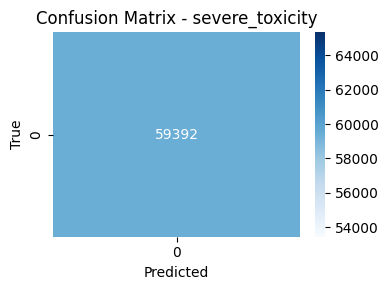


Confusion Matrix for 'obscene':
[[59392]]


C:\Users\tamer\OneDrive - Høgskulen på Vestlandet\Dokumenter\3 År\DAT255 Deep learning\toxicity2\toxicityPython39\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


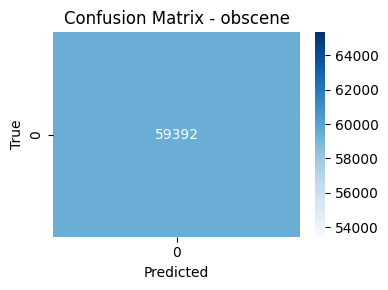


Confusion Matrix for 'threat':
[[59392]]


C:\Users\tamer\OneDrive - Høgskulen på Vestlandet\Dokumenter\3 År\DAT255 Deep learning\toxicity2\toxicityPython39\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


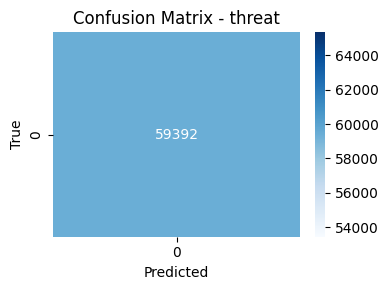


Confusion Matrix for 'insult':
[[59387     2]
 [    3     0]]


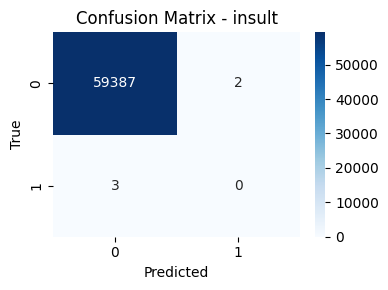


Confusion Matrix for 'identity_attack':
[[59392]]


C:\Users\tamer\OneDrive - Høgskulen på Vestlandet\Dokumenter\3 År\DAT255 Deep learning\toxicity2\toxicityPython39\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


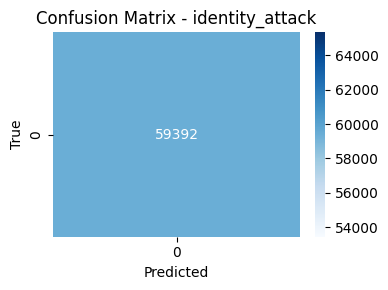


Confusion Matrix for 'sexual_explicit':
[[59391     0]
 [    1     0]]


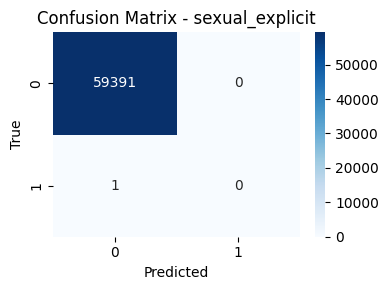


Classification Report:
                 precision    recall  f1-score   support

       toxicity       0.00      0.00      0.00         6
severe_toxicity       0.00      0.00      0.00         0

      micro avg       0.00      0.00      0.00         6
      macro avg       0.00      0.00      0.00         6
   weighted avg       0.00      0.00      0.00         6
    samples avg       0.00      0.00      0.00         6



C:\Users\tamer\OneDrive - Høgskulen på Vestlandet\Dokumenter\3 År\DAT255 Deep learning\toxicity2\toxicityPython39\lib\site-packages\sklearn\metrics\_classification.py:2687: UserWarning: labels size, 2, does not match size of target_names, 7
  warnings.warn(


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

label_names = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']

y_true = []
for batch in val:
    _, labels = batch
    y_true.append(labels)

y_true = np.concatenate([y.numpy() for y in y_true], axis=0)

y_true_binary = (y_true >= 0.5).astype(int)

y_true = np.vstack([labels.numpy() for _, labels in val])
y_pred_binary = (y_pred >= 0.5).astype(int)

for i, label in enumerate(label_names):
    print(f"\nConfusion Matrix for '{label}':")
    cm = confusion_matrix(y_true_binary[:, i], y_pred_binary[:, i])
    print(cm)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

print("\nClassification Report:")
print(classification_report(
                            y_true_binary,
                            y_pred_binary,
                            target_names=label_names,
                            zero_division=0,
                            labels=[0, 1]  
                            ))


In [118]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in val:
    X_true, y_true = batch
    
    yhat = model(X_true, training=False)
    
    y_true_binary = tf.cast(y_true >= 0.5, tf.float32)
    yhat_binary = tf.cast(yhat >= 0.5, tf.float32)

    pre.update_state(y_true_binary, yhat_binary)
    re.update_state(y_true_binary, yhat_binary)
    acc.update_state(y_true_binary, yhat_binary)

print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')


Precision: 0.0, Recall: 0.0, Accuracy: 0.9999542832374573


In [119]:
import numpy as np

all_labels = []
for _, y in val:
    all_labels.append(y.numpy())
all_labels = np.concatenate(all_labels)

print("Positive samples:", np.sum(all_labels))
print("Negative samples:", len(all_labels) - np.sum(all_labels))

Positive samples: 15.43614712357521
Negative samples: 59376.563852876425


In [120]:
for batch in val.take(1):
    X_true, y_true = batch
    yhat = model.predict(X_true)
    print("Predictions:", yhat[:10].flatten())
    print("Actual labels:", y_true[:10].numpy().flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Predictions: [1.49907137e-05 1.02519311e-06 1.89642151e-06 1.07568134e-07
 1.45508866e-05 1.30748447e-06 7.81394135e-07 5.13947962e-05
 2.88330170e-06 6.47561046e-06 3.63441160e-07 5.80702254e-05
 3.75265995e-06 1.88140143e-06 8.41184636e-04 6.28498674e-05
 5.63292779e-05 8.90049414e-05 7.02208839e-04 9.87756212e-05
 2.18060723e-05 4.95438217e-05 2.99547514e-06 5.81811082e-06
 6.19269144e-07 5.12847837e-05 4.60331739e-06 2.18508512e-06
 5.43772285e-06 3.24724482e-07 4.97041810e-07 2.97643048e-08
 5.30292255e-06 4.90595198e-07 2.38811054e-07 2.82362835e-05
 1.85650038e-06 3.51500239e-06 2.64205653e-07 2.93436478e-05
 1.76342144e-06 1.09399048e-06 1.20602399e-05 7.33569891e-07
 1.23807990e-06 8.29625648e-08 1.22263955e-05 1.17325169e-06
 5.51175447e-07 1.21566127e-05 9.20747652e-07 1.31345087e-06
 1.88047096e-07 1.04410292e-05 1.00195007e-06 6.63982803e-07
 7.07796789e-06 4.78624486e-07 8.72628107e-07 5.04384907e-08
 6.63750552e-06 4.87972784e-07 3.